## Get data

In [ ]:
!wget "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/22990/1698033/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1606260208&Signature=ZB9e4ObmPeS%2FMuWYx%2BDBI8edbwiyF2h1trXvB8Ai1BMdnbo2j%2BKPShsgvzCa4Op5WntifnoXoAfRL4ixZBI5Lk4sAToTERENAgGzSLfkgxabMSYu7e0qfIGEMPa5fNdH7UTGPuzKqNrtK1VGsxW8zP8Rw%2BiJQJE%2B9S%2BnvXtSuZEwKGeAJwcktdGoZ6bT5jWMRta3nbo9rvLnF1KdrNNRMMLap7V4pbd6hmLTcFU0z5NjVIItnY720W4ViCbwAeuiOMBaPYBGrq69RkYjWc1ztnD%2Bj204vifR6MuFyRZxyPk2nEKSIqI%2BNWS%2FmgCLVGfB7%2B5TMBRIJuizxNvxtm6cjQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dhubmap-kidney-segmentation.zip"

The name is too long, 532 chars total.
Trying to shorten...
New name is archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1606260208&Signature=ZB9e4ObmPeS%2FMuWYx+DBI8edbwiyF2h1trXvB8Ai1BMdnbo2j+KPShsgvzCa4Op5WntifnoXoAfRL4ixZBI5Lk4sAToTERENAgGzSLfkgxabMSYu7e0qfIGEMPa5fNdH7UT.
--2020-11-23 16:53:13--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/22990/1698033/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1606260208&Signature=ZB9e4ObmPeS%2FMuWYx%2BDBI8edbwiyF2h1trXvB8Ai1BMdnbo2j%2BKPShsgvzCa4Op5WntifnoXoAfRL4ixZBI5Lk4sAToTERENAgGzSLfkgxabMSYu7e0qfIGEMPa5fNdH7UTGPuzKqNrtK1VGsxW8zP8Rw%2BiJQJE%2B9S%2BnvXtSuZEwKGeAJwcktdGoZ6bT5jWMRta3nbo9rvLnF1KdrNNRMMLap7V4pbd6hmLTcFU0z5NjVIItnY720W4ViCbwAeuiOMBaPYBGrq69RkYjWc1ztnD%2Bj204vifR6MuFyRZxyPk2nEKSIqI%2BNWS%2FmgCLVGfB7%2B5TMBRIJuizxNvxtm6cjQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dhubmap-kidney-segmentation.zip
Resolving storage.goo

In [52]:
!ls test

26dc41664-anatomical-structure.json  b2dc8411c.tiff
26dc41664.tiff			     b9a3865fc-anatomical-structure.json
afa5e8098-anatomical-structure.json  b9a3865fc.tiff
afa5e8098.tiff			     c68fe75ea-anatomical-structure.json
b2dc8411c-anatomical-structure.json  c68fe75ea.tiff


In [ ]:
!unzip ar*

Archive:  archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1606260208&Signature=ZB9e4ObmPeS%2FMuWYx+DBI8edbwiyF2h1trXvB8Ai1BMdnbo2j+KPShsgvzCa4Op5WntifnoXoAfRL4ixZBI5Lk4sAToTERENAgGzSLfkgxabMSYu7e0qfIGEMPa5fNdH7UT
  inflating: HuBMAP-20-dataset_information.csv  
  inflating: sample_submission.csv   
  inflating: test/26dc41664-anatomical-structure.json  
  inflating: test/26dc41664.tiff     
  inflating: test/afa5e8098-anatomical-structure.json  
  inflating: test/afa5e8098.tiff     
  inflating: test/b2dc8411c-anatomical-structure.json  
  inflating: test/b2dc8411c.tiff     
  inflating: test/b9a3865fc-anatomical-structure.json  
  inflating: test/b9a3865fc.tiff     
  inflating: test/c68fe75ea-anatomical-structure.json  
  inflating: test/c68fe75ea.tiff     
  inflating: train.csv               
  inflating: train/0486052bb-anatomical-structure.json  
  inflating: train/0486052bb.json    
  inflating: train/0486052bb.tiff    
  inflating: train/095bf7

In [1]:
print("halo")

halo


In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import tifffile
import os
import itertools
import tensorflow as tf

In [ ]:
BASE_PATH = "."
df_train = pd.read_csv('train.csv')
slice_size = np.array([1000,1000])
model_input_size = np.array([128,128])
slices_per_image = 100

In [ ]:

def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    return img.reshape(shape).T

def read_image(image_id, scale=None):
    image = tifffile.imread(
        os.path.join(BASE_PATH, f"train/{image_id}.tiff")
    )
    if len(image.shape) == 5:
        image = image.squeeze().transpose(1, 2, 0)
    
    mask = rle2mask(
        df_train[df_train["id"] == image_id]["encoding"].values[0], 
        (image.shape[1], image.shape[0])
    )
    
    
    if scale:
        new_size = (image.shape[1] // scale, image.shape[0] // scale)
        image = cv2.resize(image, new_size)
        mask = cv2.resize(mask, new_size)

        print(f"Resized Image shape: {image.shape}")
        print(f"Resized Mask shape: {mask.shape}")
        
    return image, mask

In [ ]:
#Dataset Generator
def slice_gen(slices_per_image, training = True):
    
    def rotate_image(im,msk, angle, end_size):
        image_center = tuple(np.array(im.shape[1::-1]) / 2)
        rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
        
        image_center_arr = np.array(image_center).astype(int)
        result = cv2.warpAffine(im, rot_mat, im.shape[1::-1], flags=cv2.INTER_LINEAR)[image_center_arr[0]-end_size//2:image_center_arr[0]+end_size//2,image_center_arr[1]-end_size//2:image_center_arr[1]+end_size//2]
        
        msk = msk.astype(np.uint8)

        msk = cv2.warpAffine(msk, rot_mat, im.shape[1::-1], flags=cv2.INTER_LINEAR)[image_center_arr[0]-end_size//2:image_center_arr[0]+end_size//2,image_center_arr[1]-end_size//2:image_center_arr[1]+end_size//2]

        return result,msk
    
    blur = (15,15)
    ids = ['54f2eec69',
        'aaa6a05cc',
        'cb2d976f4',
        '0486052bb',
        'e79de561c',
        '095bf7a1f',
        '2f6ecfcdf',
        '1e2425f28',
        '54f2eec69']

    if training == True:
        ids = ids[:6]
    else:
        ids = ids[6:]
        
        
    for i in ids:
    
        image, mask = read_image(i)

        im_shape = np.array(image.shape)[:2]

        #Apply blur to get border

        mask = cv2.blur(mask * 255, blur)
        mask[(mask >= 1) & (mask <= 254)] = 255//2
        mask //= 255//2


        #Resize image and mask

        print(f"im_shape: {im_shape}, slice_size:{slice_size}, model_input_size:{model_input_size}")
        new_image_size = im_shape // (slice_size // model_input_size)

        image = cv2.resize(image, tuple(new_image_size), interpolation = cv2.INTER_AREA)
        mask = cv2.resize(mask, tuple(new_image_size), interpolation = cv2.INTER_AREA)

        im_shape = np.array(image.shape)[:2]
        
        
        for _ in range(slices_per_image):

            while True:
                
                size_prerotation = (model_input_size // np.sin(np.pi / 4) +1).astype(int)

                
                random_point = (np.random.rand(2) * (im_shape[:2] - size_prerotation)).astype(int)
                
                
                image_slice = image[random_point[0] : random_point[0] + size_prerotation[0], random_point[1] : random_point[1] + size_prerotation[1]]
                mask_slice = mask[random_point[0] : random_point[0] + size_prerotation[0], random_point[1] : random_point[1] + size_prerotation[1]]
                
                
                
                image_slice, mask_slice = rotate_image(image_slice, mask_slice, np.random.random()*360 ,model_input_size[0])
                
                
                #random_point = (np.random.rand(2) * (im_shape[:2] - model_input_size)).astype(int)
                #image_slice = image[random_point[0] : random_point[0] + model_input_size[0], random_point[1] : random_point[1] + model_input_size[1]]
                #mask_slice = mask[random_point[0] : random_point[0] + model_input_size[0], random_point[1] : random_point[1] + model_input_size[1]]
                #Check if it's empty
                
                if np.mean(mask_slice) > 0.4:
                    break

            yield (image_slice, mask_slice)

## Data sample

In [ ]:
it = slice_gen(slices_per_image,training=True)


In [ ]:
for i in range(10):
    test = next(it)
    plt.imshow(test[0])
    plt.show()
    plt.imshow(test[1], alpha=1)
    plt.show()

im_shape: [30440 22240], slice_size:[1000 1000], model_input_size:[128 128]


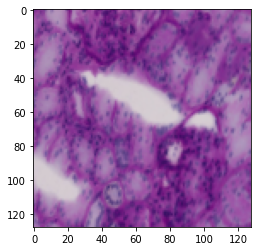

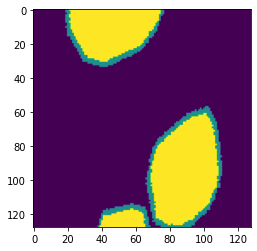

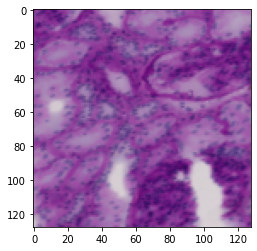

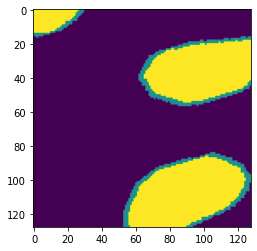

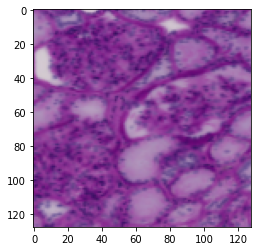

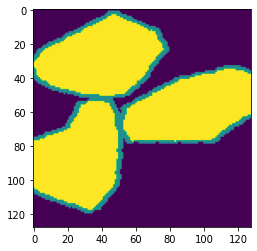

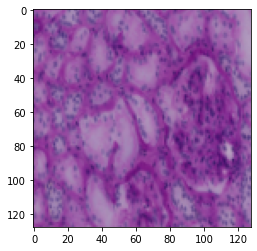

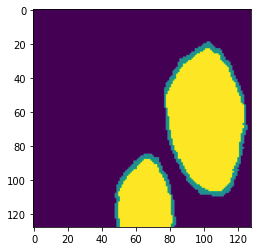

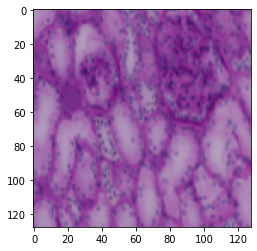

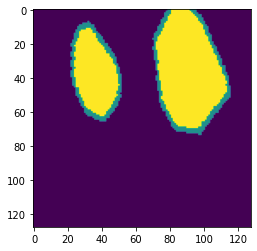

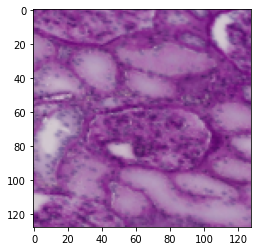

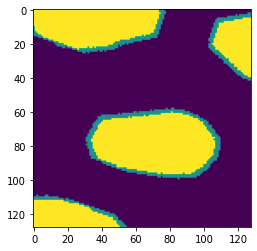

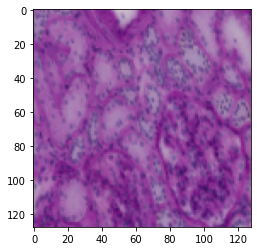

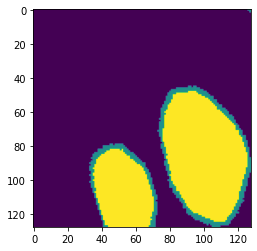

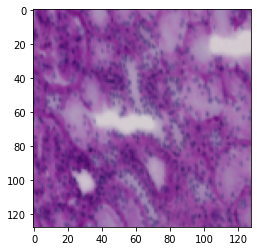

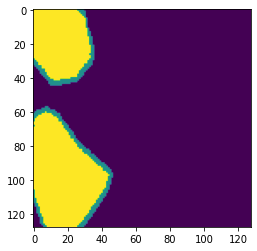

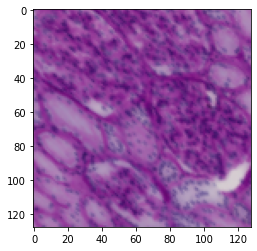

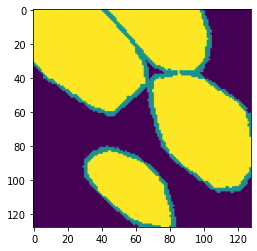

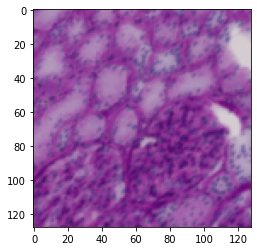

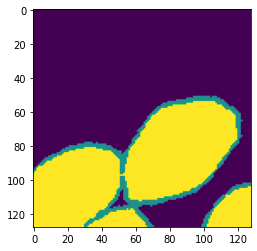

In [85]:
for i in range(10):
    test = next(it)
    plt.imshow(test[0])
    plt.show()
    plt.imshow(test[1], alpha=1)
    plt.show()

In [32]:
test[0].shape

(128, 128, 3)

In [ ]:
test[1].shape

## UNet model

In [223]:
!pip3 install git+https://github.com/tensorflow/examples.git
!pip3 install -U tfds-nightly

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-grgxkyc5
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-grgxkyc5
  fatal: unable to access 'https://github.com/tensorflow/examples.git/': Failed to connect to github.com port 443: Connection refused
ERROR: Command errored out with exit status 128: git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-grgxkyc5 Check the logs for full command output.
^C
ERROR: Operation cancelled by user


In [5]:
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds

from IPython.display import clear_output

In [37]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    #input_mask -= 1
    return input_image, input_mask

In [38]:
dataset_training = tf.data.Dataset.from_generator(
     slice_gen,
     (tf.int64,tf.int64),
     (tf.TensorShape([model_input_size[0],model_input_size[1],3]), tf.TensorShape(model_input_size)),
     args = [slices_per_image,True]
     )

dataset_test = tf.data.Dataset.from_generator(
     slice_gen,
     (tf.int64,tf.int64),
     (tf.TensorShape([model_input_size[0],model_input_size[1],3]), tf.TensorShape(model_input_size)),
     args = [slices_per_image,False]
     )


In [39]:
@tf.function
def load_image_train(image,mask):
    
    mask = tf.reshape(mask, [model_input_size[0],model_input_size[1],1])

    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    image, mask = normalize(image, mask)

    return image, mask

In [40]:
def load_image_test(image,mask):

    mask = tf.reshape(mask, [model_input_size[0],model_input_size[1],1])
    image, mask = normalize(image, mask)

    return image, mask

In [41]:
TRAIN_LENGTH = slices_per_image * 8
BATCH_SIZE = 20
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [42]:
train = dataset_training.map(load_image_train)
test = dataset_test.map(load_image_test)

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

im_shape: [30440 22240], slice_size:[1000 1000], model_input_size:[128 128]


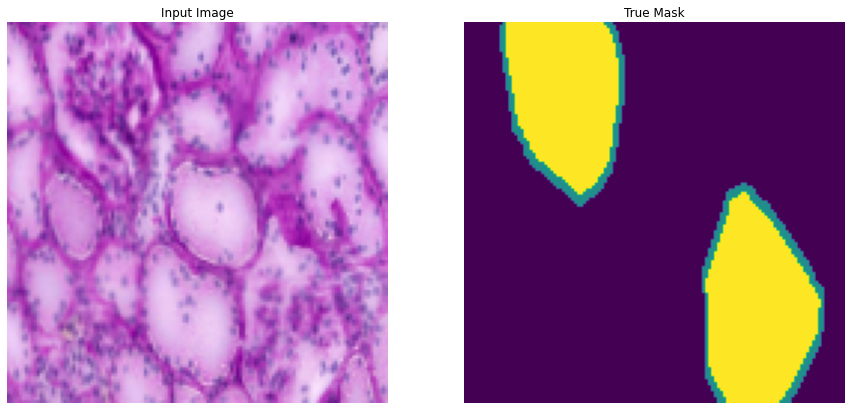

In [44]:
for image, mask in train.take(1) :
    sample_image, sample_mask = image, mask
    display([sample_image, sample_mask])

im_shape: [31278 25794], slice_size:[1000 1000], model_input_size:[128 128]


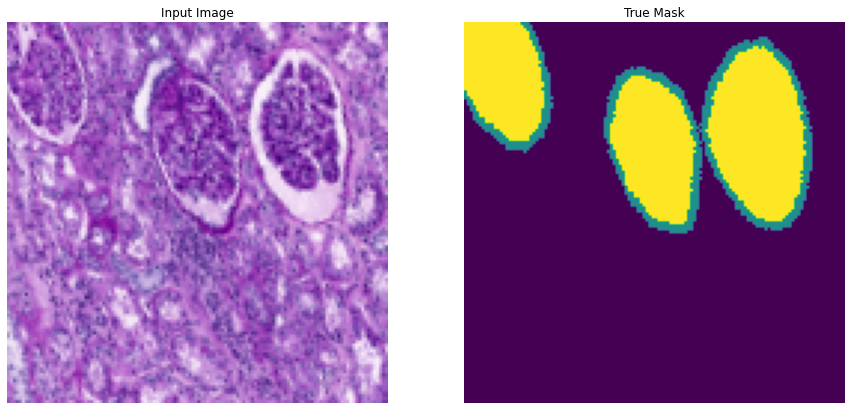

In [46]:
for image, mask in test.take(1) :
    sample_image, sample_mask = image, mask
    display([sample_image, sample_mask])

In [47]:
OUTPUT_CHANNELS = 3

In [48]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[model_input_size[0],model_input_size[1], 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [49]:
up_stack = [
    pix2pix.upsample(512, 3, apply_dropout=True),# 4x4 -> 8x8
    pix2pix.upsample(256, 3, apply_dropout=True),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [50]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [51]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [52]:
tf.keras.utils.plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [53]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [54]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [55]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [56]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
test_dataset = test.batch(BATCH_SIZE)

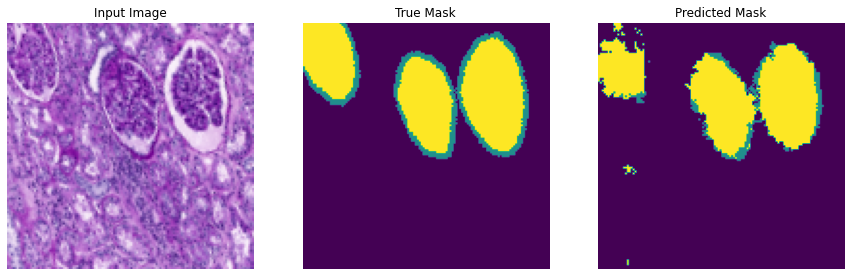


Sample Prediction after epoch 10

40/40 [==============================] - 66s 2s/step - loss: 0.2817 - accuracy: 0.8976 - val_loss: 0.2482 - val_accuracy: 0.9094


In [57]:
EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = slices_per_image * 2//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

im_shape: [31278 25794], slice_size:[1000 1000], model_input_size:[128 128]


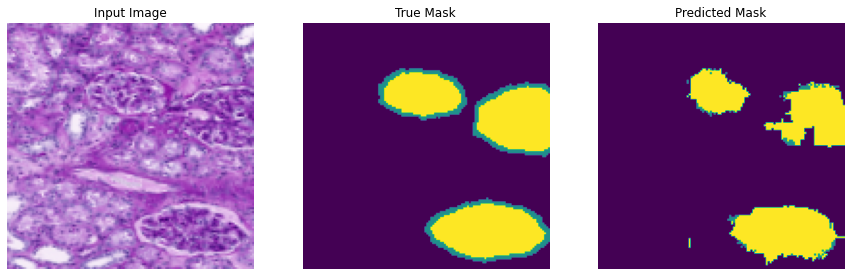

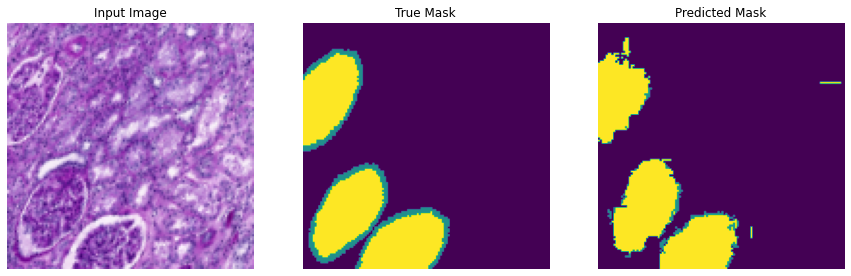

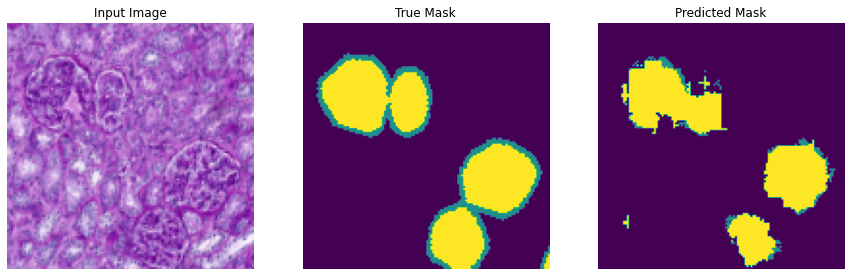

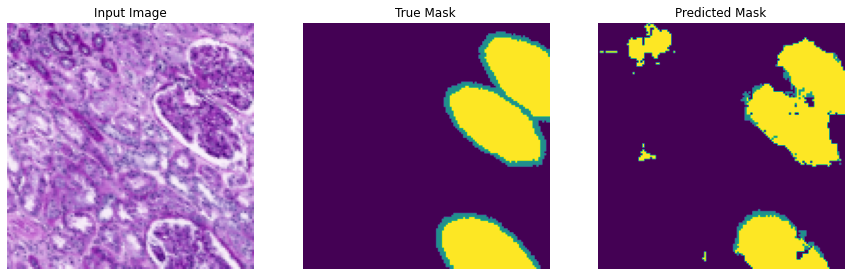

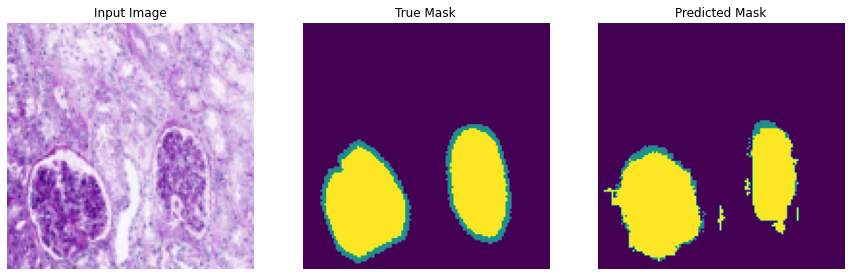

im_shape: [26780 32220], slice_size:[1000 1000], model_input_size:[128 128]


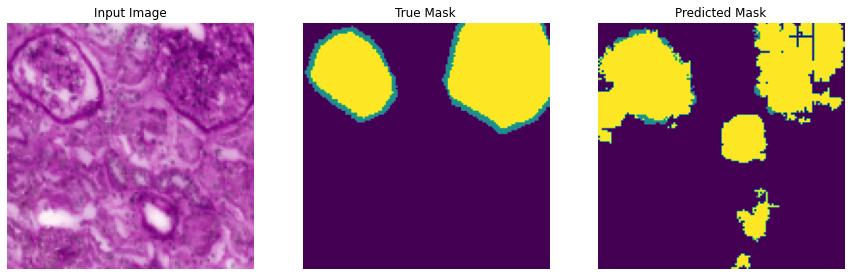

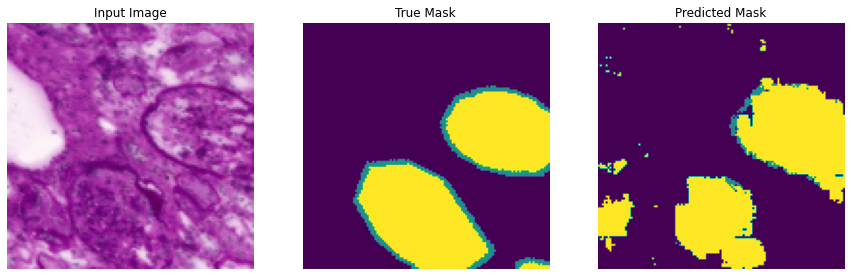

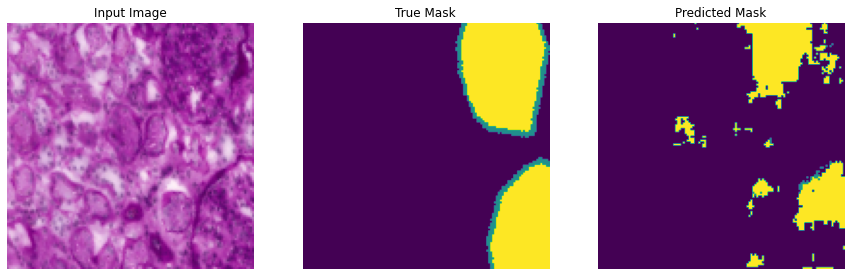

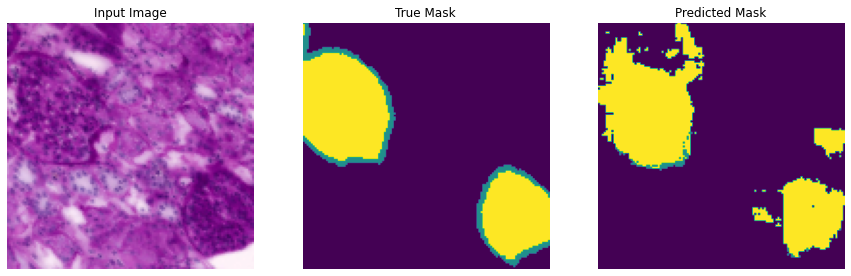

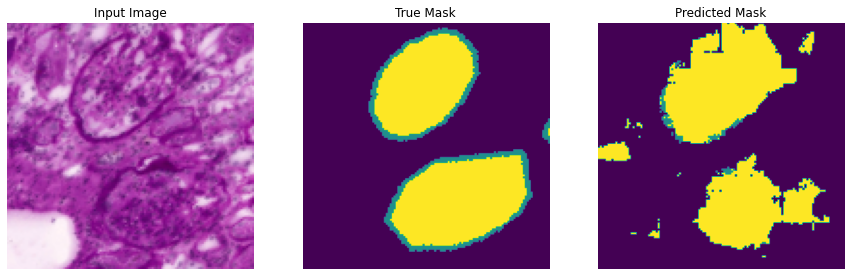

im_shape: [30440 22240], slice_size:[1000 1000], model_input_size:[128 128]


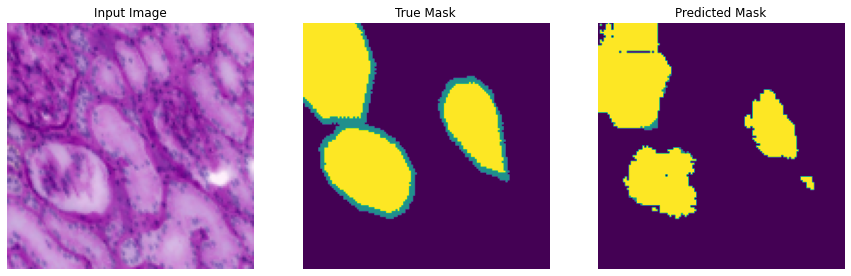

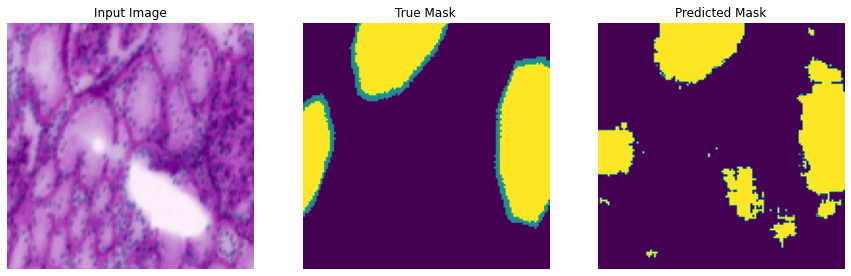

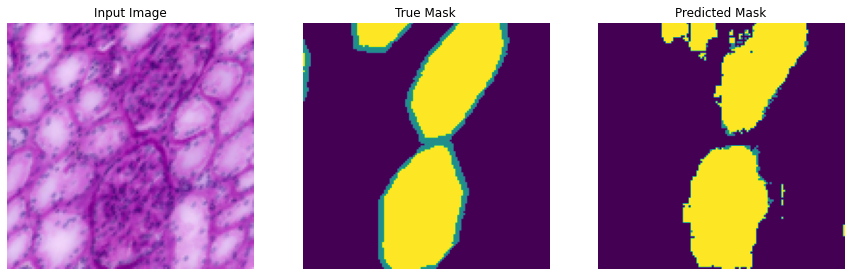

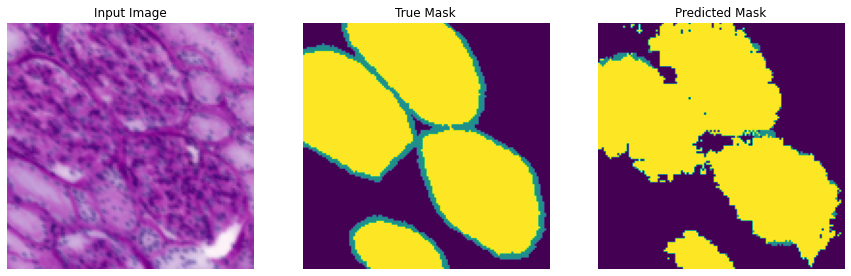

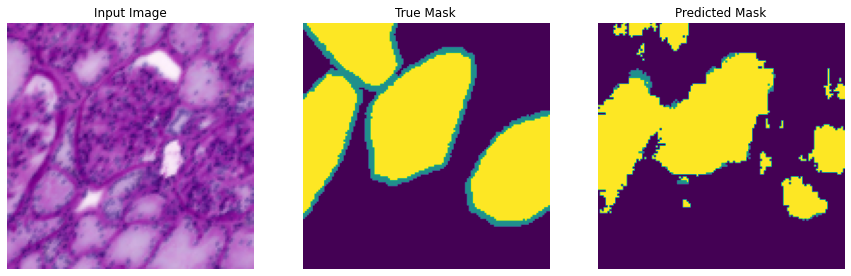

In [58]:
show_predictions(dataset = test_dataset, num=20)

In [ ]:
model_history.history.keys()

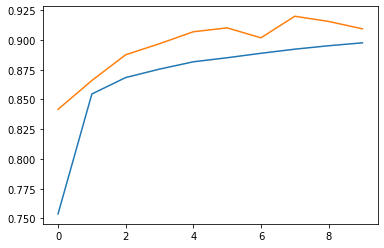

In [59]:
plt.plot(model_history.history["accuracy"])
plt.plot(model_history.history["val_accuracy"])

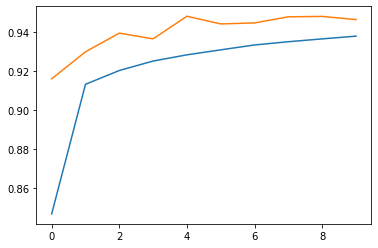

In [34]:
plt.plot(model_history.history["accuracy"])
plt.plot(model_history.history["val_accuracy"])

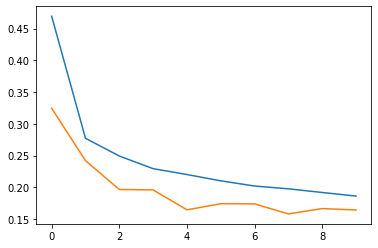

In [35]:
plt.plot(model_history.history["loss"])
plt.plot(model_history.history["val_loss"])

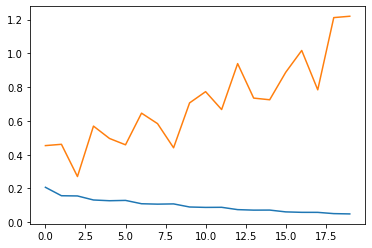

In [215]:
plt.plot(model_history.history["loss"])
plt.plot(model_history.history["val_loss"])

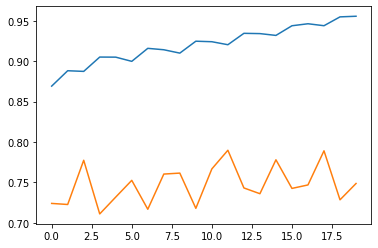

In [179]:
plt.plot(model_history.history["accuracy"])
plt.plot(model_history.history["val_accuracy"])

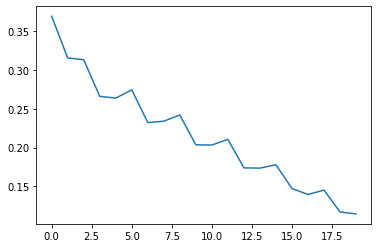

In [181]:
plt.plot(model_history.history["loss"])

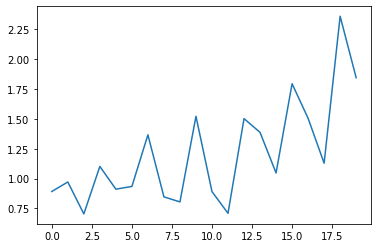

In [182]:

plt.plot(model_history.history["val_loss"])